In [1]:
try:
    evaluation = pd.read_csv('testeva.csv',index_col=0)
    evaluation = evaluation.T.sort_index()

    #droplist = ['cnn_train']
    #evaluation = evaluation.drop(droplist)

    fig,ax = plt.subplots(2)
    evaluation[['MSE','rmse']].plot.bar(ax=ax[0])
    ax[0].axhline(np.min(evaluation['MSE']),color='r',ls='--')
    ax[0].axhline(np.min(evaluation['rmse']),color='r',ls='--')

    evaluation[['NSE','R2']].plot.bar(ax=ax[1])
    ax[1].axhline(np.max(evaluation['NSE']),color='r',ls='--')
    ax[1].legend(loc='upper left')
    ax[0].legend(loc='upper left')
except: pass

In [1]:
from DLtools.Trial_evaluation_rec import record_list_result
from DLtools.Data import instant_data,station_sel
from DLtools.feature_sel import call_mar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import pywt
np.random.seed(42)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #ignore cuDNN log

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/song/anaconda3/envs/tf-gpu-c

In [2]:
from sklearn.metrics import r2_score
def forecast_accuracy(forecast, actual,title=None):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mse = np.mean((forecast - actual)**2)       #MSE

    nse = nashsutcliffe(actual,forecast)
    r2 = r2_score(actual, forecast)
    result = {'MSE':mse,'rmse':rmse,'R2':r2,'NSE':nse,'mape':mape,  'mae': mae,
            'mpe': mpe}
    result =  pd.Series(result,name=title)
    if title!=None:
        try: 
          eval = pd.read_csv('testeva.csv',index_col=0)
          pd.concat([eval,result],axis=1).to_csv('testeva.csv')
        except:
          eval = pd.DataFrame(result)
          eval.to_csv('testeva.csv')
    return result

def nashsutcliffe(Y_evaluation, Yhat_simulation):
    """
    Nash-Sutcliffe model efficinecy
        .. math::
         NSE = 1-\\frac{\\sum_{i=1}^{N}(e_{i}-s_{i})^2}{\\sum_{i=1}^{N}(e_{i}-\\bar{e})^2} 
    :evaluation: Observed data to compared with simulation data.
    :type: list
    :simulation: simulation data to compared with evaluation data
    :type: list
    :return: Nash-Sutcliff model efficiency
    :rtype: float
    """
    if len(Y_evaluation) == len(Yhat_simulation):
        s, e = np.array(Yhat_simulation), np.array(Y_evaluation)
        # s,e=simulation(Yhat),evaluation(Y)
        mean_observed = np.nanmean(e)
        # compute numerator and denominator
        numerator = np.nansum((e - s) ** 2)
        denominator = np.nansum((e - mean_observed)**2)
        # compute coefficient
        return 1 - (numerator / denominator)

In [4]:
############# Keras ###################
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
##--------------------------- SETTING AREA ------------------------------##
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
# df,mode = loading.daily_instant(),'day'
if mode =='hour': n_past,n_future = 24*7,72
elif mode =='day': n_past,n_future = 60,30
st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)

In [7]:
#--------------------------- 2 Yr Edit -----------------------------------#
host_path = './CPY012/2Yr_flood/'
start_p = '2016-01-01'
split_date = '2017-05-10'
stop_p = '2018-01-01'


In [8]:
#-----------------------Baseline / Hybrid -----------------------------------#
save_path =host_path+'trial'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [9]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
def split_xy(data,n_past,n_future):
    x,y = split_series(data.values,n_past,n_future)
    x = x.reshape((x.shape[0], x.shape[1],n_features))
    y = y[:,:,0]
    return x,y

In [10]:
#------------------------- Main ---------------------------------#
df = df[start_p:stop_p]
data = df
data['Day'] = data.index.dayofyear #add day
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')#interpolate neighbor first, for rest NA fill with mean() #.apply(lambda x: x.fillna(x.mean()),axis=0)

cutoff=.3
data_mar = call_mar(data,target,mode,cutoff=cutoff)
data_mar = move_column_inplace(data_mar,target,0)
n_features = len(data_mar.columns)

#------------------------
syn = ''
Yscale = False
allscale=True

data_mar.columns

Index(['CPY012_wl', 'NAN009_wl', 'DNP028_press', 'WAN005_wl', 'BKK021_wl',
       'PIN004_wl', 'CPY006_wl', 'BKK013_wl', 'YOM012_wl', 'WAN003_wl'],
      dtype='object')

In [12]:
def wavelet_t(series,std):
    name = series.name
    idx = series.index
    signal = series.values
    if std: signal = (signal - signal.mean())/(signal.std())

    coeff = pywt.swt(signal,'db4',level=1)
    coeff = np.array(coeff)

    cA1,cD1 = coeff[0][0],coeff[0][1]
    #_,cD2 = coeff[1][0],coeff[1][1]
    #_,cD1 = coeff[2][0],coeff[2][1]
    #----------------------------
    dict_data = {
            '{}_cA1'.format(name): cA1,
            '{}_cD1'.format(name): cD1,
            #'{}_cD2'.format(name): cD2,
            #'{}_cD1'.format(name): cD1
                }
    wt = pd.DataFrame(dict_data,dtype='float32',index=idx)
    return wt
def df_wavelet(df,std):
    wav_df = pd.DataFrame()
    for col in df:
        a = wavelet_t(df[col],std)
        wav_df = pd.concat([wav_df,a],axis=1)
    return wav_df
def syn_column_select(data,sel_word):
    data_col = [i.split("_") for i in data.columns]
    _col =list()
    for i in data_col:
        if i[2]==sel_word : 
            i='_'.join(i)
            _col.append(i)
    return data[_col]

def st_column_select(data,sel_word):
    data_col = [i.split("_") for i in data.columns]
    _col =list()
    for i in data_col:
        if i[0]==sel_word : 
            i='_'.join(i)
            _col.append(i)
    return data[_col]

In [13]:
wdata = df_wavelet(data_mar,False)
wdata_A1 = syn_column_select(wdata,'cA1')
#wdata_D3 = syn_column_select(wdata,'cD3')
#wdata_D2 = syn_column_select(wdata,'cD2')
wdata_D1 = syn_column_select(wdata,'cD1')

In [15]:
cpy = st_column_select(wdata,'CPY012')

##----------- SCALE
if allscale:
    syn = syn+'[X_sc]'  
    def scale_x(data):
        scaler = MinMaxScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])
        return data
    wdata_A1 = scale_x(wdata_A1)
    #wdata_D3 = scale_x(wdata_D3)
    #wdata_D2 = scale_x(wdata_D2)
    wdata_D1 = scale_x(wdata_D1)

# Y data
#if Yscale:
#    syn = syn+'[y_sc]'        
#    scaler_tar = MinMaxScaler()
#    scaler_tar.fit(data_mar[target].to_numpy().reshape(-1,1))
    
#scaler_tar = MinMaxScaler()
#scaler_tar.fit(data_mar[target].to_numpy().reshape(-1,1))
#data_mar[target] = scaler_tar.transform(data_mar[target].to_numpy().reshape(-1,1))

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

<AxesSubplot:xlabel='date'>

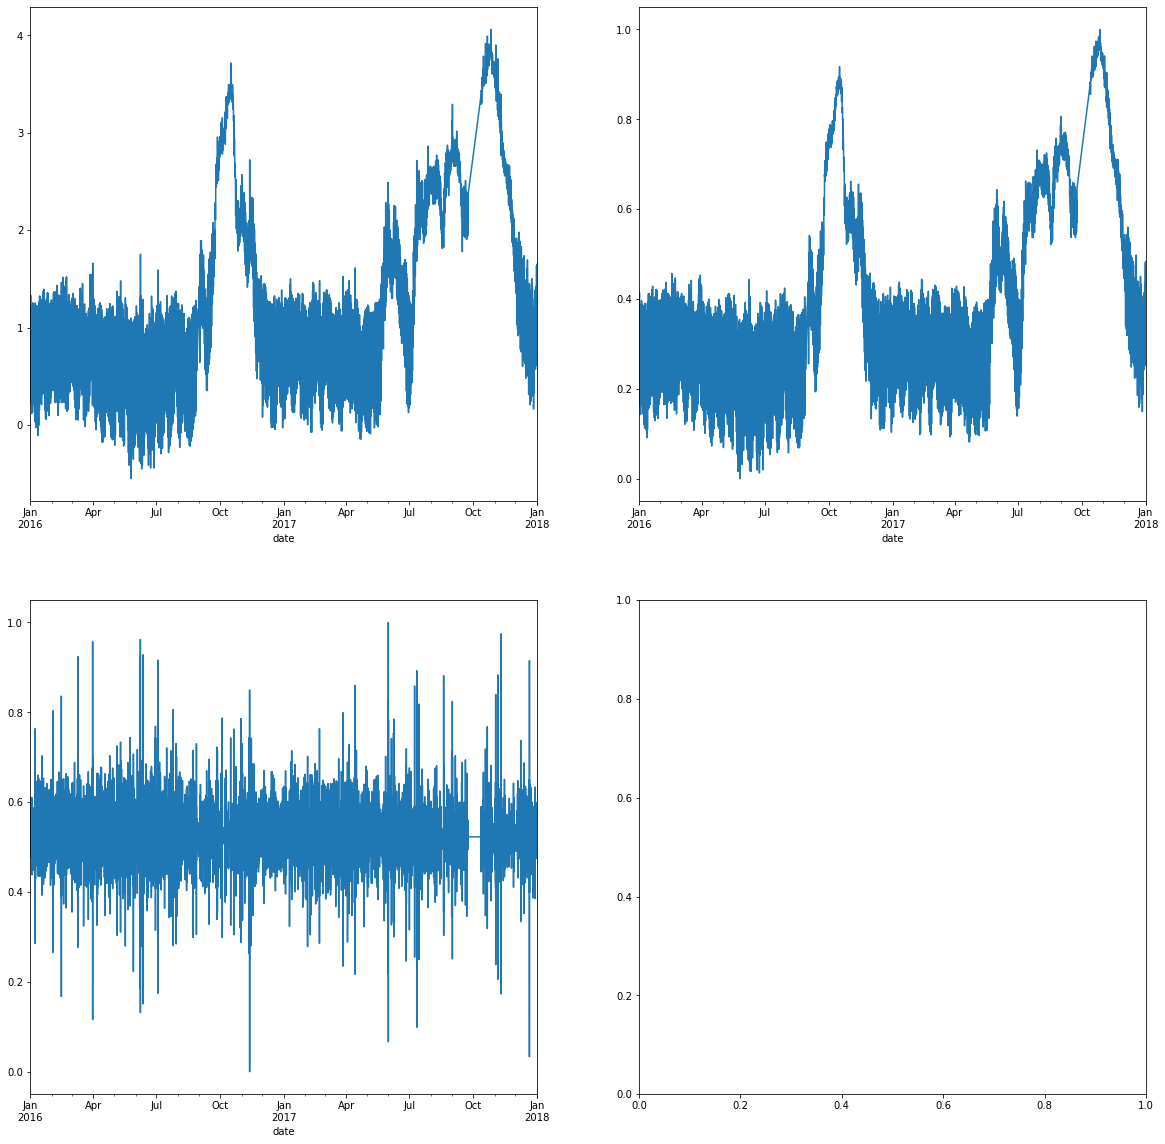

In [16]:
fig,ax = plt.subplots(2,2, figsize=(20,20))
data_mar.iloc[:,0].plot(ax=ax[0][0])
wdata_A1.iloc[:,0].plot(ax=ax[0][1])
#wdata_D3.iloc[:,0].plot(ax=ax[1][0])
#wdata_D2.iloc[:,0].plot(ax=ax[1][1])
wdata_D1.iloc[:,0].plot(ax=ax[1][0])


In [17]:
def autosplit(data):    
    ##----------- train test split 
    train,test = data[:split_date],data[split_date:]
    # ##--------- Wavelet_traintest
    X_train, y_train = split_xy(train,n_past,n_future)
    X_test, y_test= split_xy(test,n_past,n_future)
    return [X_train,X_test],[y_train,y_test]

In [18]:
Xa1,Ya1=autosplit(wdata_A1)
#Xd3,Yd3=autosplit(wdata_D3)
#Xd2,Yd2=autosplit(wdata_D2)
Xd1,Yd1=autosplit(wdata_D1)

In [21]:
c_train,c_test = cpy[:split_date],cpy[split_date:]

x,y = split_series(c_train.values,n_past,n_future)
x = x.reshape((x.shape[0], x.shape[1],2))
yA1_train = y[:,:,0]
yD1_train = y[:,:,1]
#yD2_train = y[:,:,2]
#yD1_train = y[:,:,3]
#--------------------------------------------
x,y = split_series(c_test.values,n_past,n_future)
x = x.reshape((x.shape[0], x.shape[1],2))
yA1_test = y[:,:,0]
yD1_test = y[:,:,1]
#yD2_test = y[:,:,2]
#yD1_test = y[:,:,3]


In [112]:
X_cA,Y=autosplit(wdata_A1)
X_cA[0].shape

(11665, 168, 10)

# Deep learning

In [50]:
#------------ DL PARAMETER ---------------------#
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=2, verbose=2)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-5 * 0.90 ** x)
callbacks = [callback_early_stopping,reduce_lr]
my_optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)

In [23]:
# inverse transform
def inverse_WT(cA3,cD3,cD2,cD1):
#predTrain = inverse_WT(cA3ytrain,d1_PreTrain,d1_PreTrain,d1_PreTrain)
#predTest = inverse_WT(cA3ytest,cD3ytest,cD2ytest,cD1ytest)
    wav=list()
    for i in range(cA3.shape[0]):
        iwave = pywt.iswt((cA3[i,:],cD3[i,:],cD2[i,:],cD1[i,:]),'db4')
        wav.append(iwave)
    return np.array(wav)


In [24]:
def runmodel(model,X,Y):
    history = model.fit(X[0],Y[0],epochs=epochs,validation_data=(X[1],Y[1]),batch_size=batch,verbose=verbose,callbacks=callbacks)
    trainPred = model.predict(X[0])
    testPred = model.predict(X[1])

    if Yscale:
        Y[0] = scaler_tar.inverse_transform(Y[0])
        trainPred = scaler_tar.inverse_transform(trainPred.reshape(Y[0].shape))
        Y[1] = scaler_tar.inverse_transform(Y[1])
        testPred = scaler_tar.inverse_transform(testPred.reshape(Y[1].shape))
    return trainPred,testPred

In [25]:
#----------------------------------------------------------#
def build_lstm():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    # x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model
#-------------------------------------------------------------#
def build_lstm_batch():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    # x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model
#------------------------------------------------------------#
def build_cnn1d():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(144, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer='adam', loss='mse')    
    model.summary()
    return model
#-------------------------------------------------------------#
def build_ann():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Flatten()(input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(144, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer='adam', loss='mse')    
    model.summary()
    return model

In [26]:
def showresult(Yhat,Y):
    print(forecast_accuracy(Yhat[0],Y[0]))
    print(forecast_accuracy(Yhat[1],Y[1]))

    for i in range(1,72,24):
        plt.title(syn)
        plt.plot(Y[1][:,i],alpha=0.1)
        plt.plot(Yhat[1][:,i],color='red')
    plt.legend()

CNN

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 168, 10)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 167, 64)           1344      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 83, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5312)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5312)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               1062600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0   

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


MSE     0.005302
rmse    0.072812
R2      0.780540
NSE     0.780542
mape         inf
mae     0.060329
mpe          inf
dtype: float64
MSE     0.010961
rmse    0.104696
R2      0.690373
NSE     0.690466
mape    0.150469
mae     0.085821
mpe    -0.082365
dtype: float64


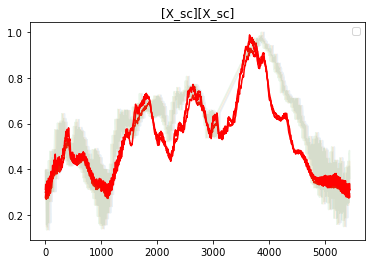

In [29]:
model_c = build_cnn1d()

verbose, epochs,batch = 0, 100,16
a1_PreTrain_c,a1_PreTest_c = runmodel(model_c,Xa1,Ya1)

showresult([a1_PreTrain_c,a1_PreTest_c],Ya1)

In [33]:
def build_mod_ann():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Flatten()(input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(144, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer='adam', loss='mse')    
    model.summary()
    return model

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 168, 10)]         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1680)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1680)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 200)               336200    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 144)               28944     
_________________________________________________________________
dense_14 (Dense)             (None, 72)                1044

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


MSE     0.009910
rmse    0.099551
R2     -3.815773
NSE    -3.815901
mape         inf
mae     0.085544
mpe          inf
dtype: float64
MSE     0.009402
rmse    0.096965
R2     -5.062356
NSE    -5.062476
mape    0.163670
mae     0.084702
mpe    -0.146849
dtype: float64


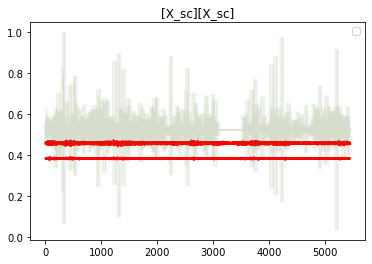

In [34]:
verbose, epochs,batch = 1, 100,16
d1_PreTrain_c,d1_PreTest_c = runmodel(build_mod_ann(),Xd1,Yd1)
showresult([d1_PreTrain_c,d1_PreTest_c],Yd1)

LSTM+batch

MSE     2.363343
rmse    1.537317
R2      0.338439
NSE     0.338425
mape    0.887117
mae     1.275214
mpe    -0.478817
dtype: float64
MSE     1.494314
rmse    1.222422
R2      0.733820
NSE     0.733775
mape    0.189482
mae     0.979614
mpe    -0.134802
dtype: float64


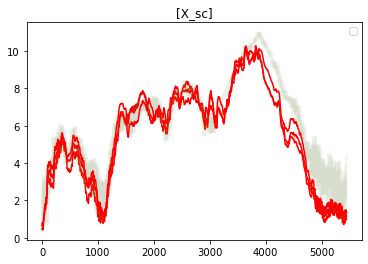

In [49]:
model_lb = build_lstm_batch()
verbose, epochs,batch = 1, 100,16
a3_PreTrain_l,a3_PreTest_l = runmodel(model_lb,Xa3,[yA3_train,yA3_test])
showresult([a3_PreTrain_l,a3_PreTest_l],[yA3_train,yA3_test])

Find best noise prediction

In [87]:
def build_dcnn():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input)
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=(2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters=64, kernel_size=2)(x)
    x = layers.Conv1D(filters=64, kernel_size=2)(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(200)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(100)(x)
    x = layers.Dense(n_future,activation='sigmoid')(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer="Adam", loss="cosine_similarity", metrics=["accuracy"])       
    model.summary()
    return model

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 167, 64)           1344      
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 166, 64)           8256      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 83, 64)            0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 83, 64)            256       
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 82, 64)            8256      
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 81, 64)            825

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


MSE       0.270978
rmse      0.520556
R2     -130.680055
NSE    -130.681290
mape           NaN
mae       0.518399
mpe            NaN
dtype: float64
MSE       0.270470
rmse      0.520067
R2     -173.395995
NSE    -173.396973
mape      0.993338
mae       0.518397
mpe      -0.812213
dtype: float64


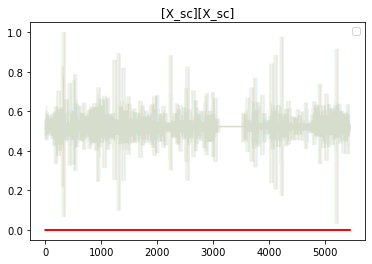

In [89]:
d1_PreTrain_g,d1_PreTest_g = runmodel(build_dcnn(),Xd1,[yD1_train,yD1_test])
showresult([d1_PreTrain_g,d1_PreTest_g],[yD1_train,yD1_test])

In [104]:
def autoen():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    # x = layers.CuDNNLSTM(200,  input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.RepeatVector(n_future)(x)
    x = layers.LSTM(200, activation='relu',return_sequences=True)(x)
    # x = layers.CuDNNLSTM(200, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(100, activation='relu'))(x)
    x = layers.TimeDistributed(layers.Dense(1))(x)
    #out = layers.Reshape((-1,n_future))(x)
    x = layers.Flatten()(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [105]:
d1_PreTrain_g,d1_PreTest_g = runmodel(autoen(),Xd1,[yD1_train,yD1_test])
showresult([d1_PreTrain_g,d1_PreTest_g],[yD1_train,yD1_test])

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               168800    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 72, 200)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 72, 200)           320800    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 72, 100)           20100     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 72, 1)             101       
_________________________________________________________________
flatten_21 (Flatten)         (None, 72)                0  

KeyboardInterrupt: 

In [107]:
showresult([d1_PreTrain_g,d1_PreTest_g],[yD1_train,yD1_test])

MemoryError: Unable to allocate 36.5 GiB for an array with shape (11665, 11665, 72) and data type float32

In [106]:
d1_PreTrain_g,d1_PreTest_g = runmodel(autoen(),Xd1,Yd1)
showresult([d1_PreTrain_g,d1_PreTest_g],Yd1)

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 200)               168800    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 72, 200)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 72, 200)           320800    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 72, 100)           20100     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 72, 1)             101       
_________________________________________________________________
flatten_22 (Flatten)         (None, 72)                0  

NameError: name 'yd1' is not defined

In [ ]:
for i in range(batch_size):
    idx=np.random.randint()